In [3]:
import numpy as np
import chess
import pandas as pd
import io
import chess.pgn
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pgntofen
from sklearn.utils import shuffle
import gc
from dataLoaderAndPreprocessing import loadData, filterAndBalanceData

### Data preprocessing and exploration

load data (chess games), and filter and balance it so that white player is always human, black is human or computer with 50 percent, and each human or computer have 50 percent winrate. This prevents that the algorithm learns to predict who won the game instead of who played computer-like moves. Also select by game length (15 to 50 moves per player).

Detecting computer use in early game stage (<15 moves) doesn't make much sense, it could just be memorized moves. Too long games are more calculation intense and computers don't typicall take that long to beat someone.

In [4]:
df= loadData()
df=filterAndBalanceData(df, 30, 100)    # game length in halfmoves/ply
len(df)

70132

In [177]:
df.head()

,BlackIsComp,PlyCount,Result,TimeControl,WhiteIsComp,moves
0,0,53,1-0,300+0,0,"[e4, c6, d4, d5, e5, Bf5, Nf3, e6, Bd3, Bxd3, ..."
1,0,56,0-1,900+0,0,"[e4, e5, Nf3, Nc6, g3, Nf6, d3, Bc5, Bg2, d6, ..."
2,0,98,1-0,900+0,0,"[e4, e5, Nf3, Nc6, c3, Bc5, Bb5, d6, Bxc6+, bx..."
3,0,39,1-0,300+0,0,"[e4, c5, Bc4, Nc6, d3, d6, Qh5, e6, Nf3, Nf6, ..."
4,1,37,0-1,900+0,0,"[d4, Nf6, c4, g6, Nc3, d5, cxd5, Nxd5, e4, Nxc..."


In [80]:
#double-check winrates and label distribution, should be all balanced
winrate_c_black=len(df[(df.BlackIsComp==1)&(df.Result=="0-1")])/len(df[(df.BlackIsComp==1)])
winrate_h_black=len(df[(df.BlackIsComp==0)&(df.Result=="0-1")])/len(df[(df.BlackIsComp==0)])
winrate_h_white=len(df[(df.WhiteIsComp==0)&(df.Result=="1-0")])/len(df[(df.WhiteIsComp==0)])

[winrate_c_black, len(df[(df.BlackIsComp==1)]),
 winrate_h_black, len(df[(df.BlackIsComp==0)]),
 winrate_h_white, len(df[(df.WhiteIsComp==0)])]

[0.5, 35066, 0.5, 35066, 0.5, 70132]

mean game length = 63.37343865852963 ply


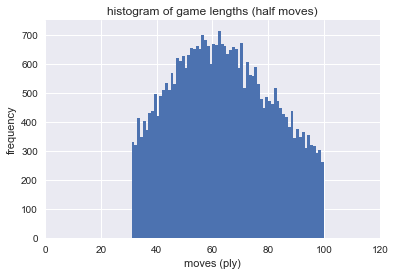

In [83]:
#check game lengths 
plt.hist(df[df.BlackIsComp==0].PlyCount, bins=range(120))
plt.xlim([0,120])
plt.xlabel("moves (ply)")
plt.ylabel("frequency")
plt.title("histogram of game lengths (half moves)")

print("mean game length = " + str(np.mean(df[df.BlackIsComp==0].PlyCount)) + " ply")
plt.show()

mean game length = 60.365510751154964 ply


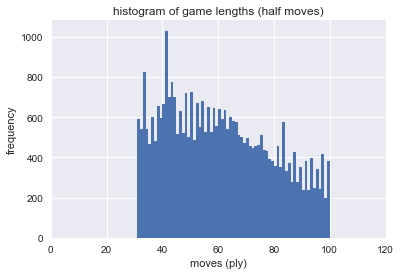

In [84]:
plt.hist(df[df.BlackIsComp==1].PlyCount, bins=range(120))
plt.xlim([0,120])
plt.xlabel("moves (ply)")
plt.ylabel("frequency")
plt.title("histogram of game lengths (half moves)")

print("mean game length = " + str(np.mean(df[df.BlackIsComp==1].PlyCount)) + " ply")
plt.show()

interesting distribution..

### Heatmaps

In [16]:
# turn pgn notation (describing the moves) into a version of the fen notation (describing the board),
# with zeros for empty squares instead of the standard notation (e.g. "00000000" instead of "8" for eight free squares)
def moves_to_fen(moves):
    fenlist=[]
    pgnConverter = pgntofen.PgnToFen()
    pgnConverter.resetBoard()
    
    for move in moves:
        pgnConverter.move(str(move))
        fen = pgnConverter.getFullFen()             
        fen=fen.split(" ")[0]
        fen=fen.replace("1","0").replace("2","00").replace("3","000").replace("4","0000")
        fen=fen.replace("5","00000").replace("6","000000").replace("7","0000000").replace("8","00000000")
        fen=list(fen.replace("/",""))
        fen=np.array(fen)
        fen=np.reshape(fen,[8,8])
        fenlist.append(fen)
    
    return fenlist

In [17]:
def fen_to_heatmap(piece, fenlist):
    heatmap=np.zeros((8,8))
    for fen in fenlist:                  
        for k in range(8):
            index=[i for i, pc in enumerate(fen[k]) if pc==piece]
            for i in index:
                heatmap[k][i]+=1
    heatmap=heatmap/len(fenlist)
    return heatmap

In [18]:
def moves_to_heatmap(moves,piece):
    fenlist=moves_to_fen(moves)
    heatmap=fen_to_heatmap(piece, fenlist)
    return heatmap

In [19]:
# get average heatmap over n_av games
def average_heatmap(piece, n_av, pgns):
    avHeatmap=np.zeros((8,8))
    for pgn in pgns[:n_av]:
        heatmap=moves_to_heatmap(pgn, piece)
        avHeatmap+=heatmap
    avHeatmap/=n_av
    return avHeatmap

In [20]:
def display_heatmap(piece, n_av, pgn):
    heatmap=average_heatmap(piece, n_av, pgn)
    ax=sns.heatmap(heatmap,xticklabels=["A","B","C","D","E","F","G","H"],yticklabels=[8,7,6,5,4,3,2,1])
    if piece.isupper():
        color = "white "
    else:
        color = "black "
    ax.set_title('Heatmap for '+ color +  piece)
    return ax

In [21]:
def displayMultHeatmap(pieces, n_av, pgn):
    for piece in pieces:
        heatmap=average_heatmap(piece, n_av, pgn)
        ax=sns.heatmap(heatmap,xticklabels=["A","B","C","D","E","F","G","H"],yticklabels=[8,7,6,5,4,3,2,1])
        if piece.isupper():
            color = "white "
        else:
            color = "black "
        ax.set_title('Heatmap for '+ color +  piece)
    
    return ax

In [22]:
pgn_whiteH=df['moves'][df.WhiteIsComp==0]
pgn_blackH=df['moves'][df.BlackIsComp==0]
pgn_blackC=df['moves'][df.BlackIsComp==1]

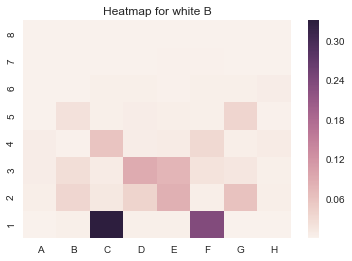

In [63]:
display_heatmap("B", 1000, pgn_whiteH)

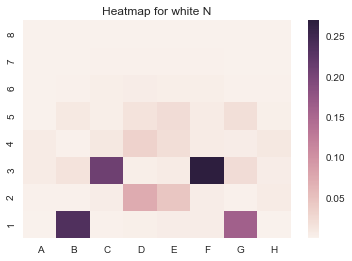

In [64]:
display_heatmap("N", 1000, pgn_whiteH)

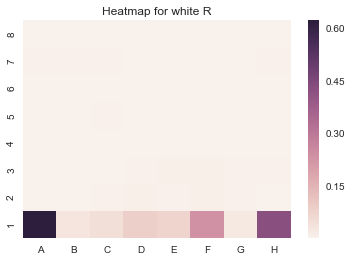

In [52]:
display_heatmap("R", 1000, pgn_whiteH)

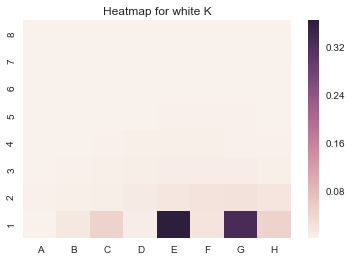

In [53]:
display_heatmap("K", 1000, pgn_whiteH)

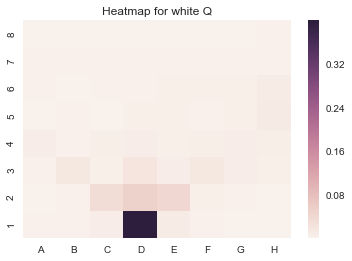

In [65]:
display_heatmap("Q", 1000, pgn_whiteH)

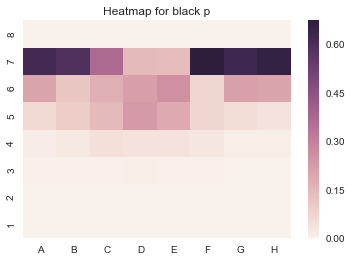

In [23]:
display_heatmap("p", 1000, pgn_blackH)

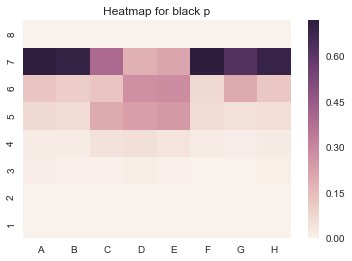

In [24]:
display_heatmap("p", 1000, pgn_blackC)

### Data preparation for Deep Learning

The idea is to create a single tensor of shape (samples x time x 12 x 8 x 8). Here 8x8 is the chess board, 12 is the 6 piece categories per color, and the first dimension is the sample index. For the time index, we'll choose the data of half-move 30 to 60, and if the game has ended before we'll save zeros as the board state, so that each tensor is of equal dimension. 

In [1]:
def getDataTensor(df, tstart, tend):
    pgns=df['moves']
    s=len(pgns)
    t=tend-tstart
    tensor=np.zeros((s, t, 12, 8, 8))
    for c, pgn in enumerate(pgns):
        game=getGame(pgn, tstart, tend)
        tensor[c]=game
    return tensor
        
def getGame(pgn, tstart, tend):
    t=tend-tstart
    game=np.zeros((t, 12, 8, 8))
    if pgn:
        fenlist = moves_to_fen(pgn)
    else:
        fenlist=[]
    while len(fenlist)<tend:
        fenlist.append(np.zeros((12,8,8)))
    fenlist=fenlist[tstart:tend]
    for c, fen in enumerate(fenlist):
        position=getPosition(fen)
        game[c]=position
    return game
        
def getPosition(fen):        
    position=np.zeros((12, 8, 8))
    pieces = ["P","R","N","B","Q","K","p","r","n","b","q","k"]
    for c, piece in enumerate(pieces):
        channel= (fen == piece)
        position[c] = channel
    return position

def saveDataAndLabels(df, tstart, tend, fname):
    data=getDataTensor(df, tstart, tend)
    labels=df['BlackIsComp']
    dataname=fname + str(tstart)+str(tend)+ "data"  
    labelname=fname + str(tstart)+str(tend)+ "labels"  
    with open(dataname, "wb") as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    with open(labelname, "wb") as file:
        pickle.dump(labels, file, pickle.HIGHEST_PROTOCOL)
    return data.shape, labels.shape, dataname, labelname

In [190]:
saveDataAndLabels(df[20000:40000], 30, 60, "chess2040k_")

C:\Users\mhamb\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


((20000, 30, 12, 8, 8),
 (20000,),
 'chess2040k_3060data',
 'chess2040k_3060labels')

In [193]:
'''some data points are giving me errors, IndexError and division by zero, still have to figure this out.
For now, I will just work with the rest...'''

for i in range(7):
    name="chess" + str(i)
    try:
        saveDataAndLabels(df[10000*i:10000*(i+1)], 30, 60, name)
    except IndexError:
        print("IndexError, run "+ str(i))
    except ZeroDivisionError:
        print("division by zero, run "+str(i))
    
    

C:\Users\mhamb\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


IndexError, run 0
IndexError, run 1
division by zero, run 4


In [194]:
saveDataAndLabels(df[50000:70000], 30, 60, "chess5070k_")

C:\Users\mhamb\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


((20000, 30, 12, 8, 8),
 (20000,),
 'chess5070k_3060data',
 'chess5070k_3060labels')

In [6]:
saveDataAndLabels(df[45000:70000], 30, 60, "chess4570k_")

C:\Users\mhamb\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


((25000, 30, 12, 8, 8),
 (25000,),
 'chess4570k_3060data',
 'chess4570k_3060labels')

In [12]:
saveDataAndLabels(df[:7000], 30, 60, "chess7k_")

C:\Users\mhamb\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


((7000, 30, 12, 8, 8), (7000,), 'chess7k_3060data', 'chess7k_3060labels')

In [14]:
saveDataAndLabels(df[10000:18000], 30, 60, "chess10k_")

C:\Users\mhamb\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


((8000, 30, 12, 8, 8), (8000,), 'chess10k_3060data', 'chess10k_3060labels')